### Importing necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import re
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from gensim.models import Word2Vec

from tqdm import tqdm
import zipfile
import requests
import os
import gensim.downloader as api
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

2023-11-15 10:12:19.775908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Problem 1: Apply Variational Autoencoder on the Fashion MNIST Dataset.

### a. Use minimum of 3 convolutional layers in the encoder and 3 deconvolutional layers (Conv2DTranspose/ upscale) in the decoder.

In [2]:
# Creating a sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# Building the encoder with 3 convolutional layers
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs) # Conv 1
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x) # Conv 2
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)  # # Conv 3
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)  # Dense layer
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 14, 14, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                                                            

In [23]:
# Building the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)  # Additional dense layer
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 6272)              18816     
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_16 (Conv2  (None, 14, 14, 64)        73792     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_17 (Conv2  (None, 28, 28, 32)        18464     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_18 (Conv2  (None, 28, 28, 1)         289 

In [14]:
# Building the modified decoder with 3 deconvolutional layers
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)  # Additional dense layer
x = layers.Reshape((7, 7, 128))(x)

# Add three deconvolutional layers
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # Upsample to (14, 14, 128)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)   # Upsample to (28, 28, 64)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)   # No upsampling, padding="same" to match the input shape

# Output layer with one channel and sigmoid activation
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

# Create the modified decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Display the summary of the modified decoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 6272)              18816     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 128)       147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 28, 28, 32)        1846

In [15]:
# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
# Load the Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist

# Split the dataset into training and testing sets
(train_images, _), (test_images, _) = fashion_mnist.load_data()

# Reshape the training images and normalize the pixel values to be in the range [0, 1] by dividing by 255
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255

In [16]:
# Load the Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255

In [17]:
# Modify the plot_label_clusters function for Fashion MNIST dataset
def plot_label_clusters_fashion(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar(scatter)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [18]:
# Train the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train_images, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 281s 593ms/step - loss: 354.0799 - reconstruction_loss: 300.2350 - kl_loss: 5.3656
Epoch 2/30
336/469 [====================>.........] - ETA: 1:24 - loss: 272.0257 - reconstruction_loss: 264.9523 - kl_loss: 6.0052

KeyboardInterrupt: 

### b. Display how the latent space clusters different classes of the training data.

1875/1875 [==============================] - 7s 4ms/step


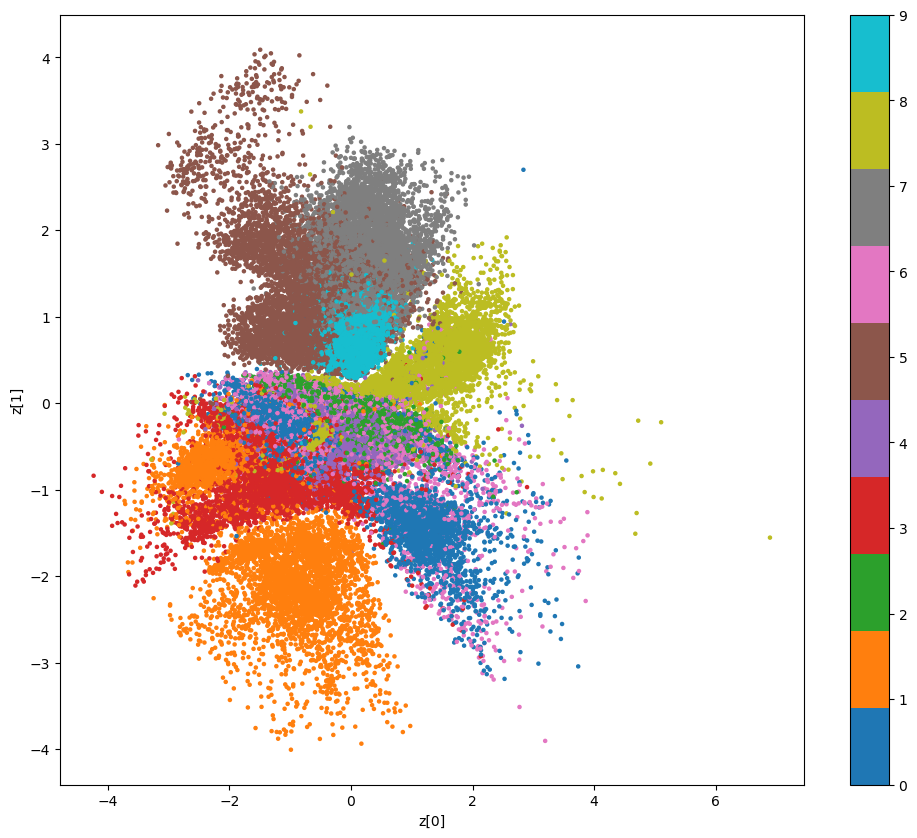

In [42]:
# Display how the latent space clusters different classes of the training data
plot_label_clusters_fashion(vae, train_images, train_labels)

### Use the IMDB Movie review dataset:
1. Perform Text Preprocessing

a. Tokenization

b. Stopwords removing

c. HTML removing

d. Convert to lower case

e. Lemmatization/stemming

In [7]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm

In [8]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Load the dataset
dfmr = pd.read_csv('IMDB_Dataset.csv')

In [11]:
dfmr

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [12]:
dfmr['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [13]:
# Function for text preprocessing
def preprocess_text(text):
    # HTML removing
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Convert to lower case
    text = text.lower()

    # Tokenization
    words = nltk.word_tokenize(text)

    # Stopwords removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a string
    processed_text = ' '.join(words)

    return processed_text

In [19]:
# Apply preprocessing to the 'reviews' column
dfmr['processed_reviews'] = dfmr['review'].apply(preprocess_text)

# Save the preprocessed data to a new CSV file
dfmr.to_csv('preprocessed_imdb_dataset.csv', index=False)

/var/folders/tz/3gc62l0518x3dtgsh9grl8540000gp/T/ipykernel_13523/3861659367.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [23]:
# Load the preprocessed dataset
dfp = pd.read_csv('preprocessed_imdb_dataset.csv')

In [24]:
dfp

,review,sentiment,processed_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching 1 oz episode '...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production . filming techniqu...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically 's family little boy ( jake ) think ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei 's `` love time money '' visuall...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job . n't creative or...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"bad plot , bad dialogue , bad acting , idiotic..."
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,negative,'m going disagree previous comment side maltin...


In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dfp['processed_reviews'], dfp['sentiment'], test_size=0.2, random_state=42)

In [26]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [27]:
# Gaussian Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train_tfidf.toarray(), y_train)

GaussianNB()

In [28]:
# Predictions
y_pred = gnb.predict(X_test_tfidf.toarray())

In [30]:
# Performance Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [31]:
# Print the performance metrics
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.7989
Confusion Matrix:
[[4000  961]
 [1050 3989]]
Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.81      0.80      4961
    positive       0.81      0.79      0.80      5039

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [46]:
# Split the dataset into training and testing sets
X = dfp['review']
y = dfp['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Tokenize and preprocess the text for Word2Vec
def tokenize_text(text):
    return text.split()

X_train_tokenized = X_train.apply(tokenize_text)
X_test_tokenized = X_test.apply(tokenize_text)

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, sg=0)

# Function to calculate the average Word2Vec vector for a document
def calculate_average_word2vec(tokens, model, vector_size):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [48]:
# Convert text to Word2Vec vectors
X_train_w2v = np.vstack([calculate_average_word2vec(tokens, word2vec_model, 100) for tokens in X_train_tokenized])
X_test_w2v = np.vstack([calculate_average_word2vec(tokens, word2vec_model, 100) for tokens in X_test_tokenized])

In [49]:
# Build and train the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train_w2v, y_train)

GaussianNB()

In [50]:
# Predict sentiment on the test set
y_pred = gnb.predict(X_test_w2v)

In [51]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [53]:
# Predictions
y_pred = gnb.predict(X_test_w2v)

In [52]:
# Display performance metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)

Accuracy: 0.6775
Confusion Matrix:
 [[3558 1403]
 [1822 3217]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.72      0.69      4961
    positive       0.70      0.64      0.67      5039

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



In [5]:
# Download the GloVe embeddings file
glove_filename = 'glove.6B.zip'

In [6]:
if not os.path.exists(glove_filename):
    response = requests.get(glove_url)
    with open(glove_filename, 'wb') as file:
        file.write(response.content)

In [7]:
dfg = pd.read_csv('preprocessed_imdb_dataset.csv')

In [8]:
X = dfg['review']
y = dfg['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Load GloVe embeddings
glove_model = api.load("glove-twitter-25")

In [10]:
# Define a function to calculate the average GloVe vector for a document
def calculate_average_glove_vector(tokens, model, vector_size):
    vectors = []
    for token in tokens:
        if token in model.vocab:
            vectors.append(model[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

In [11]:
# Tokenize and preprocess the text for GloVe embeddings
def tokenize_text(text):
    return [word for word in text.split() if word not in stopwords.words('english')]

In [12]:
X_train_tokenized = [tokenize_text(text) for text in tqdm(X_train)]
X_test_tokenized = [tokenize_text(text) for text in tqdm(X_test)]

100%|█████████████████████████████████████| 10000/10000 [16:37<00:00, 10.03it/s]


In [16]:
def calculate_average_glove_vector(tokens, model, vector_size):
    vectors = []
    for token in tokens:
        if token in model.key_to_index:
            vectors.append(model[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        # Handle the case where no vectors are found for the tokens
        return np.zeros(vector_size)

In [17]:
# Calculate average GloVe vectors for training and testing data
X_train_glove = np.vstack([calculate_average_glove_vector(tokens, glove_model, 25) for tokens in X_train_tokenized])
X_test_glove = np.vstack([calculate_average_glove_vector(tokens, glove_model, 25) for tokens in X_test_tokenized])

In [18]:
gnb = GaussianNB()
gnb.fit(X_train_glove, y_train)

GaussianNB()

In [19]:
y_pred = gnb.predict(X_test_glove)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [21]:
# Display performance metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", report)

Accuracy: 0.6787
Confusion Matrix:
 [[3669 1292]
 [1921 3118]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.74      0.70      4961
    positive       0.71      0.62      0.66      5039

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000



In [25]:
import pandas as pd
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split

# Load the pre-processed IMDB dataset
df = pd.read_csv('preprocessed_imdb_dataset.csv')

# Choose the percentage of the dataset to use
percentages = [5, 10, 15, 20]

for percentage in percentages:
    # Split the dataset
    df_sample, _ = train_test_split(df, train_size=percentage / 100, random_state=42)

    # Create a ByteLevelBPETokenizer
    tokenizer = ByteLevelBPETokenizer()

    # Train the tokenizer on the processed_reviews column
    tokenizer.train_from_iterator(df_sample['processed_reviews'].astype(str))

    # Save the tokenizer
    tokenizer.save(f'bpe_tokenizer_{percentage}percent.json')

    # Encode the reviews and count the number of tokens
    num_tokens = 0
    for review in df_sample['processed_reviews'].astype(str):
        encoding = tokenizer.encode(review)
        num_tokens += len(encoding.ids)

    print(f"{percentage}% of the dataset - Number of tokens: {num_tokens}")




5% of the dataset - Number of tokens: 431473



10% of the dataset - Number of tokens: 853775



15% of the dataset - Number of tokens: 1281675



20% of the dataset - Number of tokens: 1710502


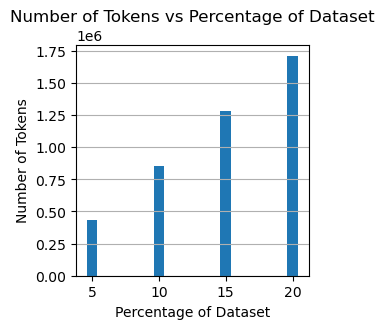

In [31]:
import matplotlib.pyplot as plt

# Results from the previous code
percentages = [5, 10, 15, 20]
num_tokens_results = [431473, 853775, 1281675, 1710502] 

# Plotting the results
plt.figure(figsize=(3, 3))
plt.bar(percentages, num_tokens_results)
plt.xlabel('Percentage of Dataset')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens vs Percentage of Dataset')
plt.xticks(percentages)
plt.grid(axis='y')

# Display the plot
plt.show()

In [33]:
import re
from collections import defaultdict
import pandas as pd

In [34]:
# BPE functions (same as before)
def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

In [35]:
def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

In [36]:
def get_vocab(data):
    vocab = defaultdict(int)
    for line in data:
        for word in line.split():
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

In [37]:
def byte_pair_encoding(data, n):
    vocab = get_vocab(data)
    for i in range(n):
        pairs = get_stats(vocab)
        best = max(pairs, key=pairs.get)
        vocab = merge_vocab(best, vocab)
    return vocab

In [52]:
def apply_bpe_to_percentage(data, percentage, n, max_lines=15):
    subset_size = int(len(data) * percentage)
    subset_data = data[:subset_size]
    bpe_pairs = byte_pair_encoding(subset_data, n)
    
    # Output a few lines of the BPE results separately
    print("\nBPE Implementation on Part of the IMDb Data:")
    line_count = 0
    for pair, merged_pair in bpe_pairs.items():
        print(f"{pair} -> {merged_pair}")
        line_count += 1
        if line_count == max_lines:
            break
    
    return bpe_pairs

In [53]:
# Load the preprocessed IMDB dataset
dataset_path = 'preprocessed_imdb_dataset.csv'
df = pd.read_csv(dataset_path)

# Percentages to evaluate
percentages = [0.05, 0.1, 0.15, 0.2]

# BPE parameters
n = 230

In [54]:
# Apply BPE for each percentage
bpe_results = {}
for percentage in percentages:
    bpe_pairs = apply_bpe_to_percentage(df['processed_reviews'], percentage, n)
    bpe_results[percentage] = bpe_pairs


BPE Implementation on Part of the IMDb Data:
one</w> -> 2552
re vi e w er</w> -> 49
m en ti on ed</w> -> 63
wat ch ing</w> -> 456
1 </w> -> 95
o z </w> -> 20
e p i s o de</w> -> 214
' l l</w> -> 321
h oo k ed</w> -> 18
.</w> -> 22870
ri ght</w> -> 329
,</w> -> 26904
ex act ly</w> -> 99
h ap p en ed</w> -> 76
me . th e</w> -> 4

BPE Implementation on Part of the IMDb Data:
one</w> -> 5241
re vi e w er</w> -> 97
m en ti on ed</w> -> 118
wat ch ing</w> -> 923
1 </w> -> 193
o z </w> -> 41
e p i s o de</w> -> 462
' l l</w> -> 625
h oo k ed</w> -> 36
.</w> -> 45816
ri ght</w> -> 652
,</w> -> 54261
ex act ly</w> -> 189
h ap p en ed</w> -> 173
me . th e</w> -> 4

BPE Implementation on Part of the IMDb Data:
one</w> -> 7838
re vi e w er</w> -> 144
m en ti on ed</w> -> 174
wat ch ing</w> -> 1378
1 </w> -> 314
o z </w> -> 51
e p i s o de</w> -> 763
' l l</w> -> 927
h oo k ed</w> -> 50
.</w> -> 69259
ri ght</w> -> 983
,</w> -> 81670
ex act ly</w> -> 290
h ap p en ed</w> -> 268
me . th e</w> -> 6


In [59]:
for percentage in percentages:
    token_reduction = 1 - (bpe_tokens / original_tokens)
    
    print(f"\nResults for {percentage * 100}% of the dataset:")
    print(f"Original Tokens: {original_tokens}")
    print(f"BPE Tokens: {bpe_tokens}")
    print(f"Token Reduction: {token_reduction:.2%}")


Results for 5.0% of the dataset:
Original Tokens: 375369
BPE Tokens: 164640
Token Reduction: 56.14%

Results for 10.0% of the dataset:
Original Tokens: 375369
BPE Tokens: 164640
Token Reduction: 56.14%

Results for 15.0% of the dataset:
Original Tokens: 375369
BPE Tokens: 164640
Token Reduction: 56.14%

Results for 20.0% of the dataset:
Original Tokens: 375369
BPE Tokens: 164640
Token Reduction: 56.14%


In [20]:
import pandas as pd
from collections import defaultdict
import re

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

def get_vocab(data):
    vocab = defaultdict(int)
    for line in data:
        for word in line.split():
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

def byte_pair_encoding(data, n):
    vocab = get_vocab(data)
    for i in range(n):
        pairs = get_stats(vocab)
        best = max(pairs, key=pairs.get)
        vocab = merge_vocab(best, vocab)
    return vocab

def apply_bpe_to_percentage(data, percentage, n, max_lines=15):
    subset_size = int(len(data) * percentage)
    subset_data = data[:subset_size]
    bpe_pairs = byte_pair_encoding(subset_data, n)
    
    # Output a few lines of the BPE results separately
    print("\nBPE Implementation on Part of the IMDb Data:")
    line_count = 0
    for pair, merged_pair in bpe_pairs.items():
        print(f"{pair} -> {merged_pair}")
        line_count += 1
        if line_count == max_lines:
            break
    
    return bpe_pairs

# Load the IMDb training dataset in CSV format
# Assuming the dataset has a column named 'text' containing the text data
imdb_data = pd.read_csv('preprocessed_imdb_dataset.csv')['processed_reviews'].tolist()

# Define the percentage of data to be used for BPE
percentage = 0.05

# Calculate the subset size
subset_size = int(len(imdb_data) * percentage)

# Create a subset of the data
subset_data = imdb_data[:subset_size]

# Define the number of iterations for BPE
n = 10  # You can adjust this based on your requirements

# Apply Byte Pair Encoding (BPE)
bpe_result = byte_pair_encoding(subset_data, n)

# Compare the BPE in terms of the number of generated tokens
original_token_count = sum(len(line.split()) for line in subset_data)
bpe_token_count = sum(len(line.split()) for line in bpe_result)

print("\nComparison of Token Counts:")
print(f"Original Token Count: {original_token_count}")
print(f"BPE Token Count: {bpe_token_count}")
print(f"Reduction in Tokens: {original_token_count - bpe_token_count}")
print(f"Reduction Percentage: {(original_token_count - bpe_token_count) / original_token_count * 100:.2f}%")


Comparison of Token Counts:
Original Token Count: 375369
BPE Token Count: 257346
Reduction in Tokens: 118023
Reduction Percentage: 31.44%


In [21]:
import pandas as pd
from collections import defaultdict
import re

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

def get_vocab(data):
    vocab = defaultdict(int)
    for line in data:
        for word in line.split():
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

def byte_pair_encoding(data, n):
    vocab = get_vocab(data)
    for i in range(n):
        pairs = get_stats(vocab)
        best = max(pairs, key=pairs.get)
        vocab = merge_vocab(best, vocab)
    return vocab

def apply_bpe_to_percentage(data, percentage, n, max_lines=15):
    subset_size = int(len(data) * percentage)
    subset_data = data[:subset_size]
    bpe_pairs = byte_pair_encoding(subset_data, n)
    
    # Output a few lines of the BPE results separately
    print("\nBPE Implementation on Part of the IMDb Data:")
    line_count = 0
    for pair, merged_pair in bpe_pairs.items():
        print(f"{pair} -> {merged_pair}")
        line_count += 1
        if line_count == max_lines:
            break
    
    return bpe_pairs

# Load the IMDb training dataset in CSV format
# Assuming the dataset has a column named 'text' containing the text data
imdb_data = pd.read_csv('preprocessed_imdb_dataset.csv')['processed_reviews'].tolist()

# Define the percentage of data to be used for BPE
percentage = 0.1

# Calculate the subset size
subset_size = int(len(imdb_data) * percentage)

# Create a subset of the data
subset_data = imdb_data[:subset_size]

# Define the number of iterations for BPE
n = 10  # You can adjust this based on your requirements

# Apply Byte Pair Encoding (BPE)
bpe_result = byte_pair_encoding(subset_data, n)

# Compare the BPE in terms of the number of generated tokens
original_token_count = sum(len(line.split()) for line in subset_data)
bpe_token_count = sum(len(line.split()) for line in bpe_result)

print("\nComparison of Token Counts:")
print(f"Original Token Count: {original_token_count}")
print(f"BPE Token Count: {bpe_token_count}")
print(f"Reduction in Tokens: {original_token_count - bpe_token_count}")
print(f"Reduction Percentage: {(original_token_count - bpe_token_count) / original_token_count * 100:.2f}%")


Comparison of Token Counts:
Original Token Count: 762255
BPE Token Count: 404520
Reduction in Tokens: 357735
Reduction Percentage: 46.93%


In [23]:
import pandas as pd
from collections import defaultdict
import re

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

def get_vocab(data):
    vocab = defaultdict(int)
    for line in data:
        for word in line.split():
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

def byte_pair_encoding(data, n):
    vocab = get_vocab(data)
    for i in range(n):
        pairs = get_stats(vocab)
        best = max(pairs, key=pairs.get)
        vocab = merge_vocab(best, vocab)
    return vocab

def apply_bpe_to_percentage(data, percentage, n, max_lines=15):
    subset_size = int(len(data) * percentage)
    subset_data = data[:subset_size]
    bpe_pairs = byte_pair_encoding(subset_data, n)
    
    # Output a few lines of the BPE results separately
    print("\nBPE Implementation on Part of the IMDb Data:")
    line_count = 0
    for pair, merged_pair in bpe_pairs.items():
        print(f"{pair} -> {merged_pair}")
        line_count += 1
        if line_count == max_lines:
            break
    
    return bpe_pairs

# Load the IMDb training dataset in CSV format
# Assuming the dataset has a column named 'text' containing the text data
imdb_data = pd.read_csv('preprocessed_imdb_dataset.csv')['processed_reviews'].tolist()

# Define the percentage of data to be used for BPE
percentage = 0.15

# Calculate the subset size
subset_size = int(len(imdb_data) * percentage)

# Create a subset of the data
subset_data = imdb_data[:subset_size]

# Define the number of iterations for BPE
n = 10  # You can adjust this based on your requirements

# Apply Byte Pair Encoding (BPE)
bpe_result = byte_pair_encoding(subset_data, n)

# Compare the BPE in terms of the number of generated tokens
original_token_count = sum(len(line.split()) for line in subset_data)
bpe_token_count = sum(len(line.split()) for line in bpe_result)

print("\nComparison of Token Counts:")
print(f"Original Token Count: {original_token_count}")
print(f"BPE Token Count: {bpe_token_count}")
print(f"Reduction in Tokens: {original_token_count - bpe_token_count}")
print(f"Reduction Percentage: {(original_token_count - bpe_token_count) / original_token_count * 100:.2f}%")


Comparison of Token Counts:
Original Token Count: 1147749
BPE Token Count: 522295
Reduction in Tokens: 625454
Reduction Percentage: 54.49%


In [24]:
import pandas as pd
from collections import defaultdict
import re

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

def get_vocab(data):
    vocab = defaultdict(int)
    for line in data:
        for word in line.split():
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

def byte_pair_encoding(data, n):
    vocab = get_vocab(data)
    for i in range(n):
        pairs = get_stats(vocab)
        best = max(pairs, key=pairs.get)
        vocab = merge_vocab(best, vocab)
    return vocab

def apply_bpe_to_percentage(data, percentage, n, max_lines=15):
    subset_size = int(len(data) * percentage)
    subset_data = data[:subset_size]
    bpe_pairs = byte_pair_encoding(subset_data, n)
    
    # Output a few lines of the BPE results separately
    print("\nBPE Implementation on Part of the IMDb Data:")
    line_count = 0
    for pair, merged_pair in bpe_pairs.items():
        print(f"{pair} -> {merged_pair}")
        line_count += 1
        if line_count == max_lines:
            break
    
    return bpe_pairs

# Load the IMDb training dataset in CSV format
# Assuming the dataset has a column named 'text' containing the text data
imdb_data = pd.read_csv('preprocessed_imdb_dataset.csv')['processed_reviews'].tolist()

# Define the percentage of data to be used for BPE
percentage = 0.20

# Calculate the subset size
subset_size = int(len(imdb_data) * percentage)

# Create a subset of the data
subset_data = imdb_data[:subset_size]

# Define the number of iterations for BPE
n = 10  # You can adjust this based on your requirements

# Apply Byte Pair Encoding (BPE)
bpe_result = byte_pair_encoding(subset_data, n)

# Compare the BPE in terms of the number of generated tokens
original_token_count = sum(len(line.split()) for line in subset_data)
bpe_token_count = sum(len(line.split()) for line in bpe_result)

print("\nComparison of Token Counts:")
print(f"Original Token Count: {original_token_count}")
print(f"BPE Token Count: {bpe_token_count}")
print(f"Reduction in Tokens: {original_token_count - bpe_token_count}")
print(f"Reduction Percentage: {(original_token_count - bpe_token_count) / original_token_count * 100:.2f}%")


Comparison of Token Counts:
Original Token Count: 1523240
BPE Token Count: 628156
Reduction in Tokens: 895084
Reduction Percentage: 58.76%


In [27]:
import pandas as pd
from collections import defaultdict
import re

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

def get_vocab(data):
    vocab = defaultdict(int)
    for line in data:
        for word in line.split():
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

def byte_pair_encoding(data, n):
    vocab = get_vocab(data)
    for i in range(n):
        pairs = get_stats(vocab)
        best = max(pairs, key=pairs.get)
        vocab = merge_vocab(best, vocab)
    return vocab

def apply_bpe_to_percentage(data, percentage, n, max_lines=5):
    subset_size = int(len(data) * percentage)
    subset_data = data[:subset_size]
    bpe_pairs = byte_pair_encoding(subset_data, n)
    
    # Output a few lines of the BPE results separately
    print(f"\nBPE Implementation on {percentage*100}% of the IMDb Data:")
    line_count = 0
    for pair, merged_pair in bpe_pairs.items():
        print(f"{pair} -> {merged_pair}")
        line_count += 1
        if line_count == max_lines:
            break
    
    return bpe_pairs

# Load the IMDb training dataset in CSV format
# Assuming the dataset has a column named 'text' containing the text data
imdb_data = pd.read_csv('preprocessed_imdb_dataset.csv')['processed_reviews'].tolist()

# Define the number of iterations for BPE
n = 10  # You can adjust this based on your requirements

# Define the percentages of data to be used for BPE
percentages = [0.05, 0.1, 0.15, 0.2]

for percentage in percentages:
    # Calculate the subset size for the current percentage
    subset_size = int(len(imdb_data) * percentage)
    
    # Create a subset of the data
    subset_data = imdb_data[:subset_size]

    # Apply Byte Pair Encoding (BPE) for the current percentage
    bpe_result = byte_pair_encoding(subset_data, n)

    # Compare the BPE for the current percentage in terms of the number of generated tokens
    original_token_count = sum(len(line.split()) for line in subset_data)
    bpe_token_count = sum(len(line.split()) for line in bpe_result)

    print(f"\nComparison of Token Counts ({percentage*100}%):")
    print(f"Original Token Count: {original_token_count}")
    print(f"BPE Token Count: {bpe_token_count}")
    print(f"Reduction in Tokens: {original_token_count - bpe_token_count}")
    print(f"Reduction Percentage: {(original_token_count - bpe_token_count) / original_token_count * 100:.2f}%")


Comparison of Token Counts (5.0%):
Original Token Count: 375369
BPE Token Count: 257346
Reduction in Tokens: 118023
Reduction Percentage: 31.44%

Comparison of Token Counts (10.0%):
Original Token Count: 762255
BPE Token Count: 404520
Reduction in Tokens: 357735
Reduction Percentage: 46.93%

Comparison of Token Counts (15.0%):
Original Token Count: 1147749
BPE Token Count: 522295
Reduction in Tokens: 625454
Reduction Percentage: 54.49%

Comparison of Token Counts (20.0%):
Original Token Count: 1523240
BPE Token Count: 628156
Reduction in Tokens: 895084
Reduction Percentage: 58.76%


In [28]:
# Assuming you have already loaded your IMDb data
imdb_data = pd.read_csv('preprocessed_imdb_dataset.csv')['processed_reviews'].tolist()

# Define the percentage of data to be used for BPE
percentage = 0.05

# Define the number of iterations for BPE
n = 10

# Call the function
result = apply_bpe_to_percentage(imdb_data, percentage, n)

# Print the result (optional)
print(result)


BPE Implementation on 5.0% of the IMDb Data:
o n e</w> -> 2552
r e v i e w er </w> -> 49
m en t i o n e d</w> -> 63
w a t c h in g</w> -> 456
1 </w> -> 95
{'o n e</w>': 2552, 'r e v i e w er </w>': 49, 'm en t i o n e d</w>': 63, 'w a t c h in g</w>': 456, '1 </w>': 95, 'o z </w>': 20, 'e p i s o d e</w>': 214, "' l l </w>": 321, 'h o o k e d</w>': 18, '.</w>': 22870, 'r i g h t</w>': 329, ',</w>': 26904, 'e x a c t l y</w>': 99, 'h a p p en e d</w>': 76, 'm e . t h e</w>': 4, 'f i r s t</w>': 820, 't h in g</w>': 789, 's t r u c k </w>': 19, 'b r u t a l i t y</w>': 5, 'u n f l in c h in g</w>': 2, 's c en e</w>': 1034, 'v i o l en c e</w>': 117, 's e t</w>': 299, 'w o r d</w>': 208, 'g o </w>': 754, 't r u s t</w>': 25, 's h o w </w>': 755, 'f a in t</w>': 6, 'h e a r t e d</w>': 5, 't i m i d</w>': 3, 'p u l l </w>': 55, 'p u n c h </w>': 29, 'r e g a r d</w>': 42, 'd r u g</w>': 103, 's e x </w>': 153, 'h a r d c o r e</w>': 11, 'c l a s s i c </w>': 197, 'u s e</w>': 190, 'w o r 